In [1]:
from proxy_methods_final import *
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import ttest_rel


/Users/alex_1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#TODO: MAKE SURE WE ARE COMPARING STANDARDISED TO STANDARDISED
#TODO  FORWARD FILL MISSING DATA
#TODO: CHECK THAT THE CORRECT PARAMS ARE BEING PASSED IN THE PROXY TIMESERIES METHOD AFTER REMOVING THE TICKER
#TODO: CHECK SOLVER

# Load data
---

In [3]:
#Prices data
#-----------------------------------------
prices_data = pd.read_csv('data/reshaped_data.csv')
prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)
prices_data = prices_data.set_index('Date')

#Index data
#-----------------------------------------
index_data = pd.read_csv('ITRAXX-Europe Timeseries 20241127.csv') #To be used for b0
index_data.rename(columns={'AsOf':'Date'}, inplace=True)
try:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d-%b-%y')
except Exception as e:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d/%b/%y')
index_data = index_data.sort_values(by='Date', ascending=True)
#Metadata
#-----------------------------------------
metadata = pd.read_csv('data/metadata.csv')

#Community detection
#-----------------------------------------
correlation_matrix,T,N,company_names = create_correlation_matrix('data/eur_data_standardized_returns.csv')
C_g = calculate_C_g(correlation_matrix, T, N)
result_communities, company_communities, modularities = recursive_spectral_method(C_g, correlation_matrix, company_names, min_size=2, modularity_threshold=0.00001)

/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_17024/1307506813.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)


# Normal CSRA vs Community CSRA
---

In [4]:
# ticker = "AF" #Defined for the purposes of getting the liquid bucket (EVEN THOUGH WE USE THE INDEX)
# date = '2015-12-30'
# liquid_bucket = get_bucket(metadata, company_communities,ticker)[0]
# metadata_with_proxies = calculate_proxies_and_add_to_metadata(metadata, company_communities, prices_data, index_data, liquid_bucket, date)
# # metadata_with_proxies.to_csv('data/metadata_with_proxies.csv', index=False)

In [5]:
#metadata_with_proxies

In [6]:
#Get matching dates in price data and index data
#-----------------------------------------
price_dates = prices_data.index.tolist()

#Extract date portion of the datetime object in the price data
index_dates = index_data['Date'].tolist()

matching_dates = [date for date in price_dates if date in index_dates]

In [7]:
tickers = prices_data.columns.to_list()[0:10] #First 10 tickers
dates = matching_dates[0:30] #First 30 dates
# CALVIN: Changed calculate_proxy_time_series to use get_bucket to obtain bucket of respective ticker
# define liquid bucket 
# liquid_bucket = {
#         'Sector': 'Financials',   
#         'Country': 'United Kingdom',
#         'Rating': 10
#     }
proxy_time_series_df = calculate_proxy_time_series(tickers, metadata, company_communities, prices_data, index_data, dates)

Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/

Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/

Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/

Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company ADIG 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ADIG 
Bucket not found for Company ADIG 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/

Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AEGON 
Bucket not found for Company AF 
Bucket not found for Company AF 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 
Bucket not found for Company AF 


/Users/alex_1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AF 


In [8]:
# #TROUBLESHOOTING
# #-----------------------------------------
# tickers = [prices_data.columns.to_list()[0]] #First ticker
# dates = matching_dates[0:1] #1 date
# # CALVIN: Changed calculate_proxy_time_series to use get_bucket to obtain bucket of respective ticker
# # define liquid bucket 
# # liquid_bucket = {
# #         'Sector': 'Financials',   
# #         'Country': 'United Kingdom',
# #         'Rating': 10
# #     }


# proxy_time_series_df = calculate_proxy_time_series(tickers, metadata, company_communities, prices_data, index_data, dates)
# proxy_time_series_df
# #-----------------------------------------

In [9]:
proxy_time_series_df

,Ticker,Date,Actual_Spread,Proxy_Intersection,Proxy_Intersection_Community,Proxy_CSRA,Proxy_CSRA_Community
0,AAUK,2010-09-14,179.666667,105.00,105.00,188.974635,127.595482
1,AAUK,2010-09-15,175.666667,105.58,105.58,188.816959,128.455038
2,AAUK,2010-09-16,174.666667,106.28,106.28,187.841878,126.074997
3,AAUK,2010-09-17,169.500000,106.96,106.96,185.686441,125.607317
4,AAUK,2010-09-20,171.833333,110.97,110.97,185.298821,125.806553
...,...,...,...,...,...,...,...
295,AF,2010-10-19,355.303434,101.62,101.62,138.016285,352.016574
296,AF,2010-10-20,359.310229,101.28,101.28,138.068778,348.833927
297,AF,2010-10-21,325.739700,98.78,98.78,134.464077,339.741876
298,AF,2010-10-22,323.543303,99.33,99.33,135.969851,342.817151


In [10]:
rmse_csra_normal_list, rmse_intersection_communities_list, rmse_csra_normal_list, rmse_csra_communities_list = calculate_rmse_curves(proxy_time_series_df, dates)

In [11]:
# diff = np.array(rmse_csra_normal_list) - np.array(rmse_csra_communities_list)


# stat, p = shapiro(diff)
# print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p}")

# if p > 0.05:
#     print("The differences appear to be normally distributed (fail to reject H0).")
# else:
#     print("The differences do not appear to be normally distributed (reject H0).")


In [12]:
# # Perform the paired t-test
# t_stat, p_value = ttest_rel(rmse_csra_normal_list, rmse_csra_communities_list)
# print(f"Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

# # Interpret the result
# alpha = 0.05  # significance level

# p_value_one_tailed = p_value / 2


# if (p_value_one_tailed < alpha) and (t_stat > 0):  # for H1: μ_d > 0
#     print("Reject the null hypothesis for a one-tailed test: Method 1 has higher RMSE.")
# else:
#     print("Fail to reject the null hypothesis for a one-tailed test.")


In [13]:
# from scipy.stats import t
# df = 9        # Degrees of freedom

# # Two-tailed p-value
# p_value_two_tailed = 2 * (1 - t.cdf(t_stat, df))

# print(p_value)
# print(p_value_two_tailed)

In [14]:
# set global plotting format
plt.style.use('seaborn-v0_8-bright')
plt.style.use('seaborn-v0_8-darkgrid')

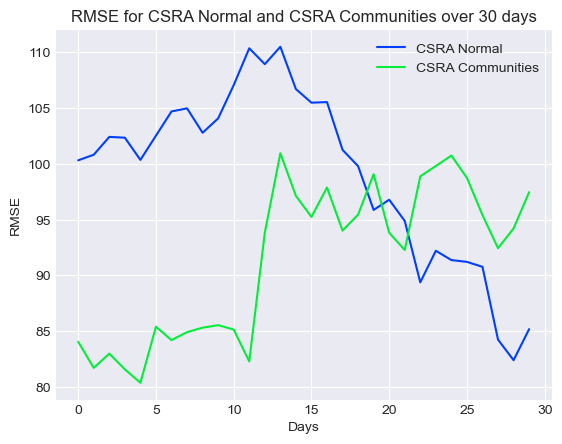

In [15]:
plot_rmse_curves(rmse_csra_normal_list, rmse_csra_communities_list, dates)

In [16]:
calculate_percentage_better(rmse_csra_normal_list, rmse_csra_communities_list)

Number of days where RMSE for normal CSRA method > RMSE for community CSRA method : 21
Percentage of days where CSRA Communities method is better: 70.0%


In [17]:
paired_t_test(rmse_csra_normal_list, rmse_csra_communities_list)

Shapiro-Wilk Test Statistic: 0.9111601710319519, p-value: 0.015919238328933716
CHECKING FOR NORMALITY OF DIFFERENCES
--------------------------------------
